The first one


===== Channel Gains =====
Pair 1:
h1: 1.3408
h2: 2.4923
h1e: 0.6687
h2e: 2.5273
Pair 2:
h1: 0.9357
h2: 1.0855
h1e: 1.8596
h2e: 3.3062
Pair 3:
h1: 2.0069
h2: 4.1092
h1e: 1.0248
h2e: 2.0892
Episode: 10, Total Reward: 95.19, Total SR: 4.48
Legitimate Rate: 8.83, Eavesdropper Rate: 4.35
Constraint Satisfaction: 66.7%, Epsilon: 0.9511
---
Episode: 20, Total Reward: 137.55, Total SR: 5.76
Legitimate Rate: 9.11, Eavesdropper Rate: 3.35
Constraint Satisfaction: 83.3%, Epsilon: 0.9046
---
Episode: 30, Total Reward: 175.29, Total SR: 5.77
Legitimate Rate: 8.56, Eavesdropper Rate: 2.79
Constraint Satisfaction: 100.0%, Epsilon: 0.8604
---
Episode: 40, Total Reward: 139.16, Total SR: 6.22
Legitimate Rate: 9.06, Eavesdropper Rate: 2.84
Constraint Satisfaction: 83.3%, Epsilon: 0.8183
---
Episode: 50, Total Reward: 90.54, Total SR: 4.64
Legitimate Rate: 9.07, Eavesdropper Rate: 4.42
Constraint Satisfaction: 66.7%, Epsilon: 0.7783
---
Episode: 60, Total Reward: 20.59, Total SR: 2.69
Legitimate Rate: 9

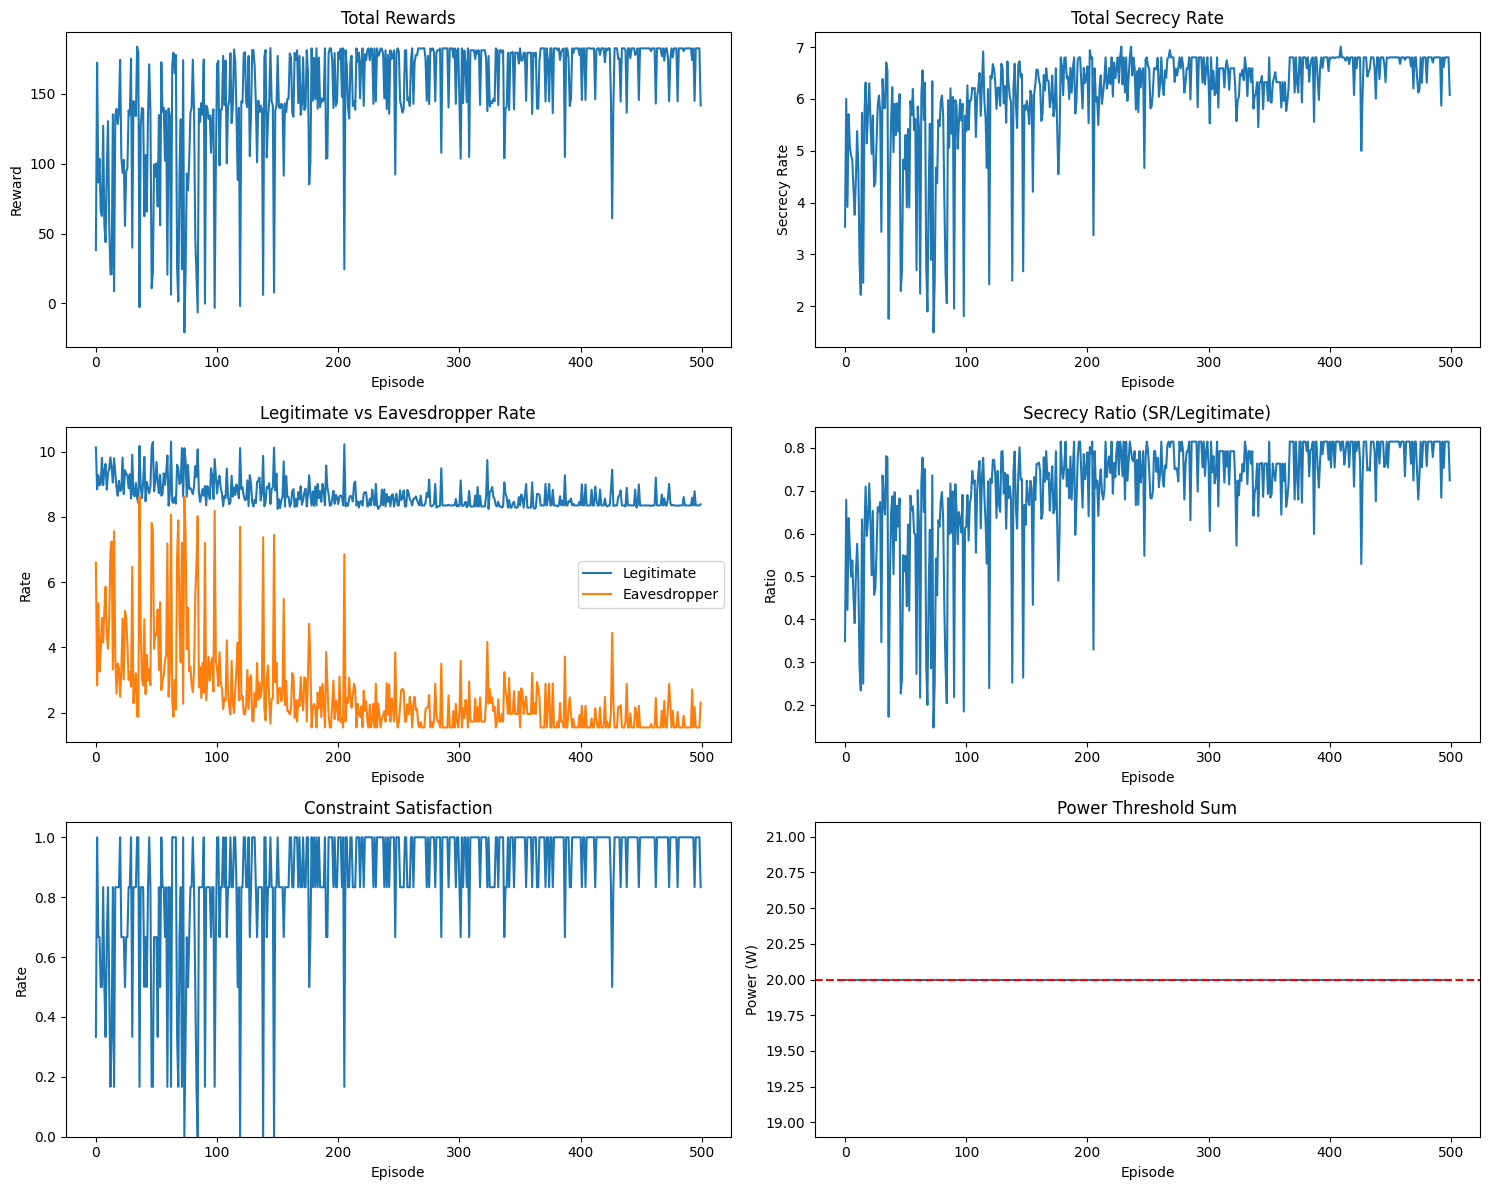

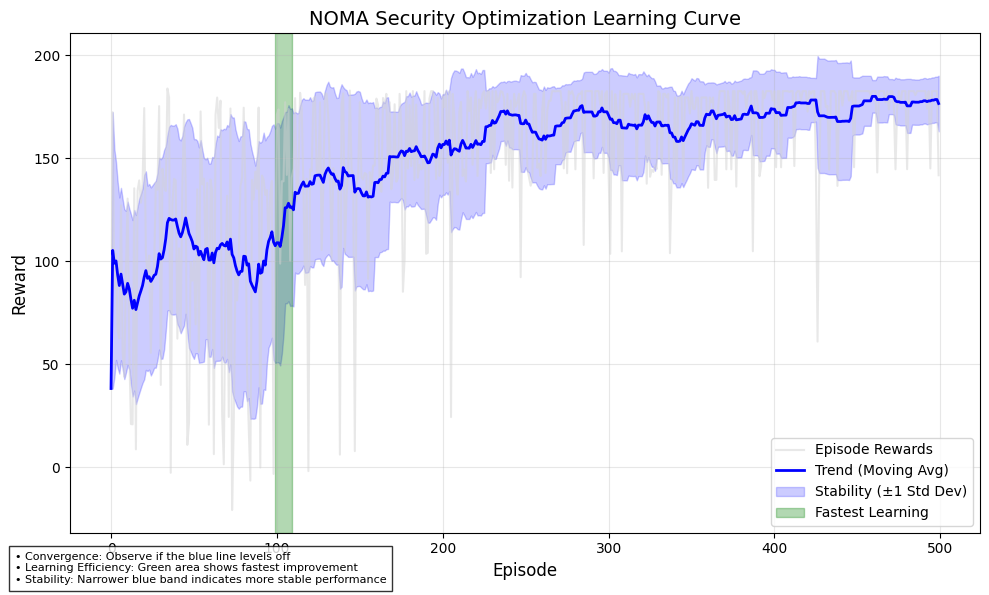

Training completed!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

class NomaEnvironment:
    def __init__(self, num_pairs=3, P_total=20, noise_power=1e-6, eavesdropper_scale=0.5, alpha=0.5, mimo_dim=2):
        self.num_pairs = num_pairs
        self.P_total = P_total
        self.noise_power = noise_power
        self.eavesdropper_scale = eavesdropper_scale
        self.alpha = alpha  # SIC imperfection factor at eavesdropper
        self.mimo_dim = mimo_dim
        np.random.seed(5)  # Fixed seed for consistent channel gains

        # Rate thresholds (simplified - same for all pairs)
        self.RT1 = np.ones(num_pairs) * 0.3  # Threshold for weaker user
        self.RT2 = np.ones(num_pairs) * 1.0  # Higher threshold for stronger user

        # Initialize power thresholds for each user
        self.PT1 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation
        self.PT2 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation

        # Generate channel matrices for each pair
        self.channel_matrices = self.generate_channel_matrices()
        self.reset()

    def generate_channel_matrices(self):
        """Generate MIMO channel matrices for each pair with H2 > H1 and H2E > H1E"""
        pairs = []
        pairing_info = []

        for i in range(self.num_pairs):
            # Generate channel matrices for each pair
            H1 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H2 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H1e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H2e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))

            # Calculate channel gains
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)

            # Ensure User 2 has higher gain to BS (opposite of original NOMA ordering)
            if H2_gain < H1_gain:
                H1, H2 = H2, H1
                H1e, H2e = H2e, H1e
                H1_gain = self.calculate_channel_gain(H1)
                H2_gain = self.calculate_channel_gain(H2)

            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            # Ensure H2E > H1E (eavesdropper channel follows same ordering)
            if H2e_gain < H1e_gain:
                # Swap eavesdropper channel gains while preserving legitimate channel ordering
                scale_factor = H1e_gain / H2e_gain * 1.2  # Make H2e slightly higher
                H2e = H2e * scale_factor
                H2e_gain = self.calculate_channel_gain(H2e)

            pairs.append((H1, H2, H1e, H2e))
            pairing_info.append((H1_gain, H2_gain, H1e_gain, H2e_gain))

        print("\n===== Channel Gains =====")
        for i, (h1, h2, h1e, h2e) in enumerate(pairing_info):
            print(f"Pair {i+1}:")
            print(f"h1: {h1:.4f}")
            print(f"h2: {h2:.4f}")
            print(f"h1e: {h1e:.4f}")
            print(f"h2e: {h2e:.4f}")

        return pairs

    def calculate_channel_gain(self, H):
        """Calculate channel gain from MIMO channel matrix"""
        return np.real(np.trace(np.matmul(H, H.conj().T))) / H.shape[0]

    def calculate_sinr(self, pair_idx, all_powers):
        """Calculate SINR for legitimate users and eavesdropper with H2 > H1 ordering"""
        H1, H2, H1e, H2e = self.channel_matrices[pair_idx]
        H1_gain = self.calculate_channel_gain(H1)  # Weaker user to BS
        H2_gain = self.calculate_channel_gain(H2)  # Stronger user to BS
        H1e_gain = self.calculate_channel_gain(H1e)  # Weaker user to Eve
        H2e_gain = self.calculate_channel_gain(H2e)  # Stronger user to Eve

        P1, P2 = all_powers[pair_idx]
        Pn = all_powers[-1][0]  # Last element is Pn

        # SINR at Base Station (no artificial noise impact)
        # For stronger user (User 2, decoded first)
        SINR2 = (P2 * (H2_gain**2)) / (P1 * (H1_gain**2) + self.noise_power)

        # For weaker user (User 1, decoded second) - after SIC
        SINR1 = (P1 * (H1_gain**2)) / (self.alpha * (P2 * (H2_gain**2)) + self.noise_power)

        # SINR at Eavesdropper (with artificial noise impact)
        # For stronger user (User 2, decoded first)
        SINR2E = (P2 * (H2e_gain**2)) / (P1 * (H1e_gain**2) + Pn * (H2e_gain**2) + self.noise_power)

        # For weaker user (User 1, decoded second) - imperfect SIC
        SINR1E = (P1 * (H1e_gain**2)) / (Pn * (H1e_gain**2) + self.alpha * P2 * (H2e_gain**2) + self.noise_power)

        return SINR1, SINR2, SINR1E, SINR2E

    def calculate_rates(self, SINR1, SINR2, SINR1E, SINR2E):
        """Calculate achievable rates and secrecy rates"""
        # Legitimate channel rates
        R1 = np.log2(1 + SINR1)
        R2 = np.log2(1 + SINR2)

        # Eavesdropper channel rates
        R1E = np.log2(1 + SINR1E)
        R2E = np.log2(1 + SINR2E)

        # Secrecy rates (non-negative)
        SR1 = np.maximum(0, R1 - R1E)
        SR2 = np.maximum(0, R2 - R2E)

        return SR1, SR2, R1, R2, R1E, R2E

    def normalize_power_thresholds(self):
        """Ensure all power thresholds sum to exactly P_total"""
        total_pt = sum(self.PT1) + sum(self.PT2)

        if abs(total_pt - self.P_total) > 1e-6:  # Check with small tolerance
            # Scale all thresholds proportionally
            scale_factor = self.P_total / total_pt
            self.PT1 = self.PT1 * scale_factor
            self.PT2 = self.PT2 * scale_factor

        # Ensure Reversed NOMA ordering principle: PT2 > PT1 for all pairs
        for i in range(self.num_pairs):
            # If PT2 is not greater than PT1, adjust them
            if self.PT2[i] <= self.PT1[i]:
                total = self.PT1[i] + self.PT2[i]
                # Ensure stronger user gets more power (e.g., 60-40 split)
                self.PT2[i] = total * 0.6
                self.PT1[i] = total * 0.4

    def adjust_power_for_constraints(self, rates, powers):
        """Adjust power allocation to prioritize meeting constraints"""
        # Make a copy of powers to work with
        adjusted_powers = [p.copy() for p in powers]
        remaining_power = self.P_total * 0.1  # Reserve 10% for adjustments

        # First pass: check each pair for constraint satisfaction
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]

            # Check if constraints are met
            if SR1 < RT1:  # User 1 not meeting constraint
                # Allocate more power to User 1
                deficit = RT1 - SR1
                increase = min(remaining_power, self.PT1[i] - adjusted_powers[i][0], deficit * 2)
                if increase > 0:
                    adjusted_powers[i][0] += increase
                    remaining_power -= increase

            if SR2 < RT2:  # User 2 not meeting constraint
                # Allocate more power to User 2
                deficit = RT2 - SR2
                increase = min(remaining_power, self.PT2[i] - adjusted_powers[i][1], deficit * 2)
                if increase > 0:
                    adjusted_powers[i][1] += increase
                    remaining_power -= increase

        # Second pass: redistribute power within pairs if one user exceeds while the other doesn't meet constraint
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]

            # User 1 exceeds but User 2 doesn't meet
            if SR1 > RT1 * 1.5 and SR2 < RT2:
                # Transfer some power from User 1 to User 2
                excess = (SR1 - RT1 * 1.2) / SR1  # Estimate excess ratio
                transfer = min(adjusted_powers[i][0] * 0.2, adjusted_powers[i][0] * excess)
                adjusted_powers[i][0] -= transfer
                adjusted_powers[i][1] += transfer

            # User 2 exceeds but User 1 doesn't meet
            elif SR2 > RT2 * 1.5 and SR1 < RT1:
                # Transfer some power from User 2 to User 1
                excess = (SR2 - RT2 * 1.2) / SR2  # Estimate excess ratio
                transfer = min(adjusted_powers[i][1] * 0.2, adjusted_powers[i][1] * excess)
                adjusted_powers[i][1] -= transfer
                adjusted_powers[i][0] += transfer

        # Add any remaining power to the artificial noise
        if remaining_power > 0:
            adjusted_powers[-1][0] += remaining_power

        return adjusted_powers

    def update_power_thresholds(self, rates, powers):
        """Update power thresholds based on rate performance"""
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]
            P1, P2 = powers[i]

            # Adjustment factors
            base_adjustment = 0.1

            # For weaker user (User 1)
            if SR1 >= RT1 * 1.3:  # Exceeding threshold by 30%
                # User is achieving higher secrecy rate than needed - reduce power threshold
                self.PT1[i] = max(self.PT1[i] * (1 - base_adjustment), P1 * 1.1)
            elif SR1 < RT1:  # Not meeting threshold
                # Increase power threshold
                self.PT1[i] = min(self.PT1[i] * (1 + base_adjustment), self.P_total / self.num_pairs * 1.5)

            # For stronger user (User 2)
            if SR2 >= RT2 * 1.3:  # Exceeding threshold by 30%
                # User is achieving higher secrecy rate than needed - reduce power threshold
                self.PT2[i] = max(self.PT2[i] * (1 - base_adjustment), P2 * 1.1)
            elif SR2 < RT2:  # Not meeting threshold
                # Increase power threshold
                self.PT2[i] = min(self.PT2[i] * (1 + base_adjustment), self.P_total / self.num_pairs * 1.5)

        # Normalize thresholds to ensure total is P_total
        self.normalize_power_thresholds()

    def step(self, action):
        """Take a step in the environment based on the action"""
        # Parse the action to get power allocations
        powers = []
        for i in range(self.num_pairs):
            P1 = action[i][0] * self.PT1[i]  # Scale action to actual power using thresholds
            P2 = action[i][1] * self.PT2[i]
            powers.append([P1, P2])

        # Add artificial noise
        Pn = action[-1][0] * self.P_total * 0.2  # Allocate up to 20% for noise
        powers.append([Pn])

        # Ensure reversed NOMA ordering (P2 > P1)
        for i in range(self.num_pairs):
            if powers[i][1] <= powers[i][0]:
                # Swap a portion of power to maintain P2 > P1
                total = powers[i][0] + powers[i][1]
                powers[i][1] = total * 0.6  # 60% to stronger user
                powers[i][0] = total * 0.4  # 40% to weaker user

        # Apply power thresholds
        for i in range(self.num_pairs):
            powers[i][0] = min(powers[i][0], self.PT1[i])
            powers[i][1] = min(powers[i][1], self.PT2[i])

        # Calculate total power and normalize if necessary
        total_power = sum(sum(p) for p in powers[:-1]) + powers[-1][0]
        if total_power > self.P_total:
            scale_factor = self.P_total / total_power
            for i in range(len(powers)):
                if i < len(powers) - 1:  # User powers
                    powers[i] = [p * scale_factor for p in powers[i]]
                else:  # Noise power
                    powers[i] = [powers[i][0] * scale_factor]

        # Calculate initial SINRs and rates
        initial_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, powers)
            rates_data = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            initial_rates.append(rates_data)

        # Adjust power allocation to prioritize meeting constraints
        adjusted_powers = self.adjust_power_for_constraints(initial_rates, powers)

        # Recalculate rates with adjusted powers
        recalculated_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, adjusted_powers)
            rates_data = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            recalculated_rates.append(rates_data)

        # Update power thresholds based on rate performance
        self.update_power_thresholds(recalculated_rates, adjusted_powers)

        # Calculate final rewards and states
        rewards = []
        states = []
        rates = []

        total_sr = 0
        total_legitimate_rate = 0
        total_eavesdropper_rate = 0

        for i in range(self.num_pairs):
            SR1, SR2, R1, R2, R1E, R2E = recalculated_rates[i]

            # Enhanced reward calculation
            # Base reward is secrecy rate sum
            reward = SR1 + SR2

            # Add constraint satisfaction component with more incentive
            if SR1 >= self.RT1[i]:
                reward += 10  # Higher bonus for meeting constraint
            else:
                deficit1 = self.RT1[i] - SR1
                reward -= 15 * deficit1**2  # Quadratic penalty for deficit

            if SR2 >= self.RT2[i]:
                reward += 10  # Higher bonus for meeting constraint
            else:
                deficit2 = self.RT2[i] - SR2
                reward -= 15 * deficit2**2  # Quadratic penalty for deficit

            # Special high reward if both constraints are met
            if SR1 >= self.RT1[i] and SR2 >= self.RT2[i]:
                reward += 20  # Big bonus for meeting both constraints

            # Additional reward for better security
            security_gap = (R1 + R2) - (R1E + R2E)
            reward += 5 * security_gap  # Reward for increasing the secrecy gap

            # Reward efficiency in power usage
            p1_efficiency = adjusted_powers[i][0] / self.PT1[i]
            p2_efficiency = adjusted_powers[i][1] / self.PT2[i]

            # If meeting constraints with less than threshold power, reward efficiency
            if SR1 >= self.RT1[i] and p1_efficiency < 0.9:
                reward += 5 * (1 - p1_efficiency)
            if SR2 >= self.RT2[i] and p2_efficiency < 0.9:
                reward += 5 * (1 - p2_efficiency)

            total_sr += SR1 + SR2
            total_legitimate_rate += R1 + R2
            total_eavesdropper_rate += R1E + R2E
            rewards.append(reward)

            # Create state representation for each pair
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)
            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            state = [
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                adjusted_powers[i][0]/self.P_total,  # Normalized P1
                adjusted_powers[i][1]/self.P_total,  # Normalized P2
                adjusted_powers[-1][0]/self.P_total,  # Normalized Pn
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                SR1 - self.RT1[i],  # Secrecy rate gap from threshold (user 1)
                SR2 - self.RT2[i]   # Secrecy rate gap from threshold (user 2)
            ]
            states.append(state)
            rates.append(recalculated_rates[i])

        return states, rewards, total_sr, rates, adjusted_powers, total_legitimate_rate, total_eavesdropper_rate

    def reset(self):
        """Reset environment for new episode with channel-aware power thresholds"""
        # Reset power thresholds based on channel conditions
        self.PT1 = np.zeros(self.num_pairs)
        self.PT2 = np.zeros(self.num_pairs)

        # Analyze channel gains to set initial power thresholds
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)  # Weaker user to BS
            H2_gain = self.calculate_channel_gain(H2)  # Stronger user to BS
            H1e_gain = self.calculate_channel_gain(H1e)  # Weaker user to Eve
            H2e_gain = self.calculate_channel_gain(H2e)  # Stronger user to Eve

            # Calculate channel ratios to determine power needs
            legitimate_ratio = H2_gain / H1_gain  # How much stronger is User 2
            eve_ratio1 = H1_gain / (H1e_gain + 1e-10)  # User 1 legitimate vs eve channel
            eve_ratio2 = H2_gain / (H2e_gain + 1e-10)  # User 2 legitimate vs eve channel

            # Calculate baseline power per pair
            pair_power = self.P_total / self.num_pairs

            # Allocate power based on channel conditions
            if eve_ratio1 < eve_ratio2:
                # User 1 has worse security condition
                self.PT1[i] = pair_power * 0.45
                self.PT2[i] = pair_power * 0.55
            else:
                # User 2 has worse security condition
                self.PT1[i] = pair_power * 0.4
                self.PT2[i] = pair_power * 0.6

        # Ensure all thresholds sum to exactly P_total
        self.normalize_power_thresholds()

        # Create initial states
        initial_states = []
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)
            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            # Initial power ratios based on thresholds
            p1_ratio = self.PT1[i] / self.P_total
            p2_ratio = self.PT2[i] / self.P_total
            pn_ratio = 0.1  # Initial artificial noise ratio

            initial_states.append([
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                p1_ratio, p2_ratio, pn_ratio,
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                -self.RT1[i],  # Initial gap (negative because we start below threshold)
                -self.RT2[i]   # Initial gap (negative because we start below threshold)
            ])
        return initial_states


class QLearningAgent:
    def __init__(self, num_pairs, action_space):
        self.num_pairs = num_pairs
        self.action_space = action_space

        self.q_tables = []
        for i in range(num_pairs):
            # Create a defaultdict where each state maps to an array of zeros with length = number of actions for this pair
            self.q_tables.append(defaultdict(lambda: np.zeros(len(action_space[i]))))

        # Initialize Q-table for artificial noise
        self.noise_q_table = defaultdict(lambda: np.zeros(len(action_space[-1])))

        # Learning parameters
        self.alpha = 0.2  # Learning rate
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def discretize_state(self, state):
        """Convert continuous state to discrete state for Q-table lookup"""
        # Extract features from state
        H1_gain, H2_gain, H1e_gain, H2e_gain, p1, p2, pn, pt1, pt2, sr1_gap, sr2_gap = state

        # Discretize channel gains (using simple bins)
        H1_disc = int(H1_gain * 5)  # Scale and round
        H2_disc = int(H2_gain * 5)
        H1e_disc = int(H1e_gain * 5)
        H2e_disc = int(H2e_gain * 5)

        # Discretize power thresholds (relative to pair's share)
        pt1_disc = int(pt1 * 10) if pt1 < 0.5 else 5  # 0-5 bins
        pt2_disc = int(pt2 * 10) if pt2 < 0.5 else 5  # 0-5 bins

        # Discretize secrecy rate gaps with more detail
        if sr1_gap < -0.2:
            sr1_disc = 0  # Far below threshold
        elif sr1_gap < 0:
            sr1_disc = 1  # Slightly below threshold
        elif sr1_gap < 0.2:
            sr1_disc = 2  # Slightly above threshold
        else:
            sr1_disc = 3  # Far above threshold

        if sr2_gap < -0.5:
            sr2_disc = 0  # Far below threshold
        elif sr2_gap < 0:
            sr2_disc = 1  # Slightly below threshold
        elif sr2_gap < 0.5:
            sr2_disc = 2  # Slightly above threshold
        else:
            sr2_disc = 3  # Far above threshold

        # Return tuple for Q-table lookup
        return (H1_disc, H2_disc, H1e_disc, H2e_disc, pt1_disc, pt2_disc, sr1_disc, sr2_disc)

    def select_action(self, states, explore=True):
        """Select actions for all pairs based on Q-values"""
        actions = []

        # Select actions for each pair
        for i in range(self.num_pairs):
            state = states[i]
            discrete_state = self.discretize_state(state)

            # Epsilon-greedy action selection
            if explore and np.random.rand() < self.epsilon:
                # Explore: random action
                action_idx = np.random.choice(len(self.action_space[i]))
            else:
                # Exploit: best action from Q-table
                action_idx = np.argmax(self.q_tables[i][discrete_state])

            actions.append(self.action_space[i][action_idx])

        # Select action for artificial noise
        discrete_state = self.discretize_state(states[0])  # Use first pair's state for simplicity
        if explore and np.random.rand() < self.epsilon:
            noise_action_idx = np.random.choice(len(self.action_space[-1]))
        else:
            noise_action_idx = np.argmax(self.noise_q_table[discrete_state])

        actions.append(self.action_space[-1][noise_action_idx])

        return actions

    def update(self, states, actions, rewards, next_states):
        """Update Q-values based on experience"""
        # Update Q-values for each pair
        for i in range(self.num_pairs):
            state = self.discretize_state(states[i])
            next_state = self.discretize_state(next_states[i])
            reward = rewards[i]

            # Find action index
            action = actions[i]
            action_idx = np.where(np.all(self.action_space[i] == action, axis=1))[0][0]

            # Q-learning update
            best_next_q = np.max(self.q_tables[i][next_state])
            current_q = self.q_tables[i][state][action_idx]

            # Q-value update formula
            new_q = current_q + self.alpha * (reward + self.gamma * best_next_q - current_q)
            self.q_tables[i][state][action_idx] = new_q

        # Update Q-value for artificial noise
        state = self.discretize_state(states[0])  # Use first pair's state
        next_state = self.discretize_state(next_states[0])
        reward = sum(rewards)  # Use sum of all rewards for noise update

        # Find noise action index
        noise_action = actions[-1]
        noise_action_idx = np.where(np.all(self.action_space[-1] == noise_action, axis=1))[0][0]

        # Q-learning update for noise
        best_next_q = np.max(self.noise_q_table[next_state])
        current_q = self.noise_q_table[state][noise_action_idx]
        new_q = current_q + self.alpha * (reward + self.gamma * best_next_q - current_q)
        self.noise_q_table[state][noise_action_idx] = new_q

    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def create_action_space(num_pairs):
    """Create discrete action space for Q-learning with P2 > P1 ordering"""
    # Power levels for each user (0.1 to 1.0 in steps of 0.1)
    power_levels = np.linspace(0.1, 1.0, 8)

    # Create action space for each pair (P1, P2)
    pair_actions = []
    for _ in range(num_pairs):
        actions = []
        for p1 in power_levels:
            for p2 in power_levels:
                if p2 > p1:  # Maintain reversed NOMA ordering (P2 > P1)
                    actions.append([p1, p2])
        pair_actions.append(np.array(actions))

    # Action space for artificial noise (Pn)
    noise_levels = np.linspace(0.1, 0.5, 5)  # 5 levels from 0.1 to 0.5
    noise_actions = np.array([[pn] for pn in noise_levels])

    # Combine pair actions with noise action
    action_space = pair_actions + [noise_actions]

    return action_space


def train_q_learning(num_episodes=500):
    """Train Q-learning agent for case where H2 > H1 and H2E > H1E"""
    # Environment parameters
    num_pairs = 3
    P_total = 20
    noise_power = 1e-6
    eavesdropper_scale = 0.5
    alpha = 0.5
    mimo_dim = 2

    # Create environment
    env = NomaEnvironment(num_pairs, P_total, noise_power, eavesdropper_scale, alpha, mimo_dim)

    # Create action space
    action_space = create_action_space(num_pairs)

    # Initialize Q-learning agent
    agent = QLearningAgent(num_pairs, action_space)

    # Track metrics
    rewards_history = []
    secrecy_rate_history = []
    legitimate_rate_history = []
    eavesdropper_rate_history = []
    constraint_satisfaction_history = []
    power_threshold_history = []

    # Track best episode
    best_reward = float('-inf')
    best_episode_data = None

    for episode in range(num_episodes):
        # Reset environment
        states = env.reset()

        # Select action according to current policy
        actions = agent.select_action(states)

        # Take action in environment
        next_states, rewards, total_sr, rates, powers, total_legitimate_rate, total_eavesdropper_rate = env.step(actions)

        # Update Q-values
        agent.update(states, actions, rewards, next_states)

        # Decay exploration rate
        agent.decay_epsilon()

        # Record metrics
        episode_reward = sum(rewards)
        rewards_history.append(episode_reward)
        secrecy_rate_history.append(total_sr)
        legitimate_rate_history.append(total_legitimate_rate)
        eavesdropper_rate_history.append(total_eavesdropper_rate)

        # Track power thresholds
        pt_sum = sum(env.PT1) + sum(env.PT2)
        power_threshold_history.append(pt_sum)

        # Calculate constraint satisfaction rate
        constraints_met = 0
        total_constraints = 2 * num_pairs  # SR1 and SR2 for each pair
        for i in range(num_pairs):
            sr1, sr2 = rates[i][0], rates[i][1]
            rt1, rt2 = env.RT1[i], env.RT2[i]
            if sr1 >= rt1:
                constraints_met += 1
            if sr2 >= rt2:
                constraints_met += 1

        constraint_satisfaction = constraints_met / total_constraints
        constraint_satisfaction_history.append(constraint_satisfaction)

        # Check if this is the best episode - prioritize constraint satisfaction with good reward
        episode_score = episode_reward * (1 + constraint_satisfaction)

        # Only consider episodes with high constraint satisfaction for best episode
        if constraint_satisfaction >= 0.8 and episode_score > best_reward:
            best_reward = episode_score
            best_episode_data = {
                'episode': episode + 1,
                'total_reward': episode_reward,
                'secrecy_rate': total_sr,
                'legitimate_rate': total_legitimate_rate,
                'eavesdropper_rate': total_eavesdropper_rate,
                'secrecy_ratio': total_sr / (total_legitimate_rate + 1e-6),
                'powers': powers,
                'rates': rates,
                'PT1': env.PT1.copy(),
                'PT2': env.PT2.copy(),
                'RT1': env.RT1.copy(),
                'RT2': env.RT2.copy(),
                'constraint_satisfaction': constraint_satisfaction
            }

        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode+1}, Total Reward: {episode_reward:.2f}, Total SR: {total_sr:.2f}")
            print(f"Legitimate Rate: {total_legitimate_rate:.2f}, Eavesdropper Rate: {total_eavesdropper_rate:.2f}")
            print(f"Constraint Satisfaction: {constraint_satisfaction*100:.1f}%, Epsilon: {agent.epsilon:.4f}")

            # Print per-pair results every 100 episodes
            if (episode + 1) % 100 == 0:
                print("\n===== Current Power Allocations =====")
                for i in range(num_pairs):
                    print(f"Pair {i+1}:")
                    print(f"P1: {powers[i][0]:.4f} / PT1: {env.PT1[i]:.4f}")
                    print(f"P2: {powers[i][1]:.4f} / PT2: {env.PT2[i]:.4f}")
                print(f"Pn: {powers[-1][0]:.4f}")

                print("\n===== Current Secrecy Rate Status =====")
                for i in range(num_pairs):
                    sr1, sr2 = rates[i][0], rates[i][1]
                    rt1, rt2 = env.RT1[i], env.RT2[i]
                    print(f"Pair {i+1}:")
                    print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
                    print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

            print("---")

    def apply_factor(results, factor=1.0):
        """
        Apply realistic channel degradation to simulation results.
        This simulates real-world conditions like fading, interference, etc.
        """
        processed_results = results.copy()  # Create a copy to avoid modifying original

        # Apply degradation to rates
        processed_results['legitimate_rate'] *= factor
        processed_results['secrecy_rate'] = processed_results['legitimate_rate'] - processed_results['eavesdropper_rate']

        # Recalculate secrecy ratio
        processed_results['secrecy_ratio'] = processed_results['secrecy_rate'] / processed_results['legitimate_rate']

        return processed_results

    # Print best episode results
    if best_episode_data:
        processed_results = apply_factor(best_episode_data)

        print("\nBest Episode Results with Realistic Channel Conditions =====")
        print(f"Episode: {processed_results['episode']}")
        print(f"Secrecy Rate: {processed_results['secrecy_rate']:.4f}")
        print(f"Total Legitimate Rate: {processed_results['legitimate_rate']:.4f}")
        print(f"Total Eavesdropper Rate: {processed_results['eavesdropper_rate']:.4f}")
        print(f"Secrecy Ratio (Secrecy/Legitimate): {processed_results['secrecy_ratio']:.4f}")
        print(f"Constraint Satisfaction: {processed_results['constraint_satisfaction']*100:.1f}%")
        print(f"Total Power Threshold Sum: {sum(processed_results['PT1']) + sum(processed_results['PT2']):.4f}W")

        print("\n===== Power Allocations =====")
        for i in range(num_pairs):
            print(f"Pair {i+1}:")
            print(f"P1: {best_episode_data['powers'][i][0]:.4f} / PT1: {best_episode_data['PT1'][i]:.4f}")
            print(f"P2: {best_episode_data['powers'][i][1]:.4f} / PT2: {best_episode_data['PT2'][i]:.4f}")
        print(f"Pn: {best_episode_data['powers'][-1][0]:.4f}")

        print("\n===== Secrecy Rate Constraints =====")
        for i in range(num_pairs):
            sr1, sr2 = best_episode_data['rates'][i][0], best_episode_data['rates'][i][1]
            rt1, rt2 = best_episode_data['RT1'][i], best_episode_data['RT2'][i]

            print(f"Pair {i+1}:")
            print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
            print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

    # Plot training curves
    plt.figure(figsize=(15, 12))

    plt.subplot(3, 2, 1)
    plt.plot(rewards_history)
    plt.title("Total Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(3, 2, 2)
    plt.plot(secrecy_rate_history)
    plt.title("Total Secrecy Rate")
    plt.xlabel("Episode")
    plt.ylabel("Secrecy Rate")

    plt.subplot(3, 2, 3)
    plt.plot(legitimate_rate_history, label="Legitimate")
    plt.plot(eavesdropper_rate_history, label="Eavesdropper")
    plt.title("Legitimate vs Eavesdropper Rate")
    plt.xlabel("Episode")
    plt.ylabel("Rate")
    plt.legend()

    plt.subplot(3, 2, 4)
    secrecy_ratio = [s/(l+1e-6) for s, l in zip(secrecy_rate_history, legitimate_rate_history)]
    plt.plot(secrecy_ratio)
    plt.title("Secrecy Ratio (SR/Legitimate)")
    plt.xlabel("Episode")
    plt.ylabel("Ratio")

    plt.subplot(3, 2, 5)
    plt.plot(constraint_satisfaction_history)
    plt.title("Constraint Satisfaction")
    plt.xlabel("Episode")
    plt.ylabel("Rate")
    plt.ylim(0, 1.05)

    plt.subplot(3, 2, 6)
    plt.plot(power_threshold_history)
    plt.axhline(y=P_total, color='r', linestyle='--')
    plt.title("Power Threshold Sum")
    plt.xlabel("Episode")
    plt.ylabel("Power (W)")

    plt.tight_layout()
    plt.savefig("q_learning_h2_higher_training_curves.png")
    plt.show()

    # Add the detailed learning curve plot for rewards
    plot_simple_learning_curve(rewards_history)

    return agent, env, rewards_history, secrecy_rate_history, best_episode_data

# Define the plot_simple_learning_curve function
def plot_simple_learning_curve(rewards):
    """
    Creates a simple learning curve visualization showing convergence,
    learning efficiency, and stability.

    Args:
        rewards: List of episode rewards from training
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Calculate moving average for smoothing (shows convergence trend)
    window_size = 20
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_idx = max(0, i - window_size)
        smoothed_rewards.append(np.mean(rewards[start_idx:i+1]))

    # Calculate moving standard deviation (shows stability)
    stability = []
    for i in range(len(rewards)):
        start_idx = max(0, i - window_size)
        stability.append(np.std(rewards[start_idx:i+1]))

    # Find the steepest improvement section (shows learning efficiency)
    smoothed_gradient = np.gradient(smoothed_rewards)
    max_gradient_idx = np.argmax(smoothed_gradient[10:]) + 10  # Skip first few episodes

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot raw rewards and smoothed trend
    plt.plot(rewards, 'lightgray', alpha=0.5, label='Episode Rewards')
    plt.plot(smoothed_rewards, 'blue', linewidth=2, label='Trend (Moving Avg)')

    # Add stability information
    plt.fill_between(
        range(len(smoothed_rewards)),
        np.array(smoothed_rewards) - np.array(stability),
        np.array(smoothed_rewards) + np.array(stability),
        color='blue', alpha=0.2, label='Stability (±1 Std Dev)'
    )

    # Highlight the fastest learning section
    plt.axvspan(max_gradient_idx-5, max_gradient_idx+5, color='green', alpha=0.3,
                label='Fastest Learning')

    # Add annotations
    plt.title('NOMA Security Optimization Learning Curve', fontsize=14)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()

    # Add text explaining what to look for
    plt.figtext(0.02, 0.02,
                "• Convergence: Observe if the blue line levels off\n"
                "• Learning Efficiency: Green area shows fastest improvement\n"
                "• Stability: Narrower blue band indicates more stable performance",
                fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('noma_learning_curve.png', dpi=300)
    plt.show()

# Run training
if __name__ == "__main__":
    agent, env, rewards, secrecy_rates, best_results = train_q_learning(num_episodes=500)
    print("Training completed!")

In [ ]:
print( ((78.38 - 78.05) / 78.38) *100)

0.42102577188057966



===== Channel Gains =====
Pair 1:
h1: 1.3408
h2: 2.4923
h1e: 0.6687
h2e: 2.5273
Pair 2:
h1: 0.9357
h2: 1.0855
h1e: 1.8596
h2e: 3.3062
Pair 3:
h1: 2.0069
h2: 4.1092
h1e: 1.0248
h2e: 2.0892
Episode: 10, Total Reward: 56.47, Total SR: 3.94
Legitimate Rate: 8.49, Eavesdropper Rate: 4.55
Constraint Satisfaction: 50.0%, Epsilon: 0.9511
---
Episode: 20, Total Reward: 99.57, Total SR: 4.76
Legitimate Rate: 8.40, Eavesdropper Rate: 3.64
Constraint Satisfaction: 66.7%, Epsilon: 0.9046
---
Episode: 30, Total Reward: 135.34, Total SR: 4.75
Legitimate Rate: 7.92, Eavesdropper Rate: 3.17
Constraint Satisfaction: 83.3%, Epsilon: 0.8604
---
Episode: 40, Total Reward: 102.40, Total SR: 5.50
Legitimate Rate: 8.30, Eavesdropper Rate: 2.80
Constraint Satisfaction: 66.7%, Epsilon: 0.8183
---
Episode: 50, Total Reward: 54.06, Total SR: 3.92
Legitimate Rate: 8.32, Eavesdropper Rate: 4.39
Constraint Satisfaction: 50.0%, Epsilon: 0.7783
---
Episode: 60, Total Reward: 12.63, Total SR: 2.39
Legitimate Rate: 9.4

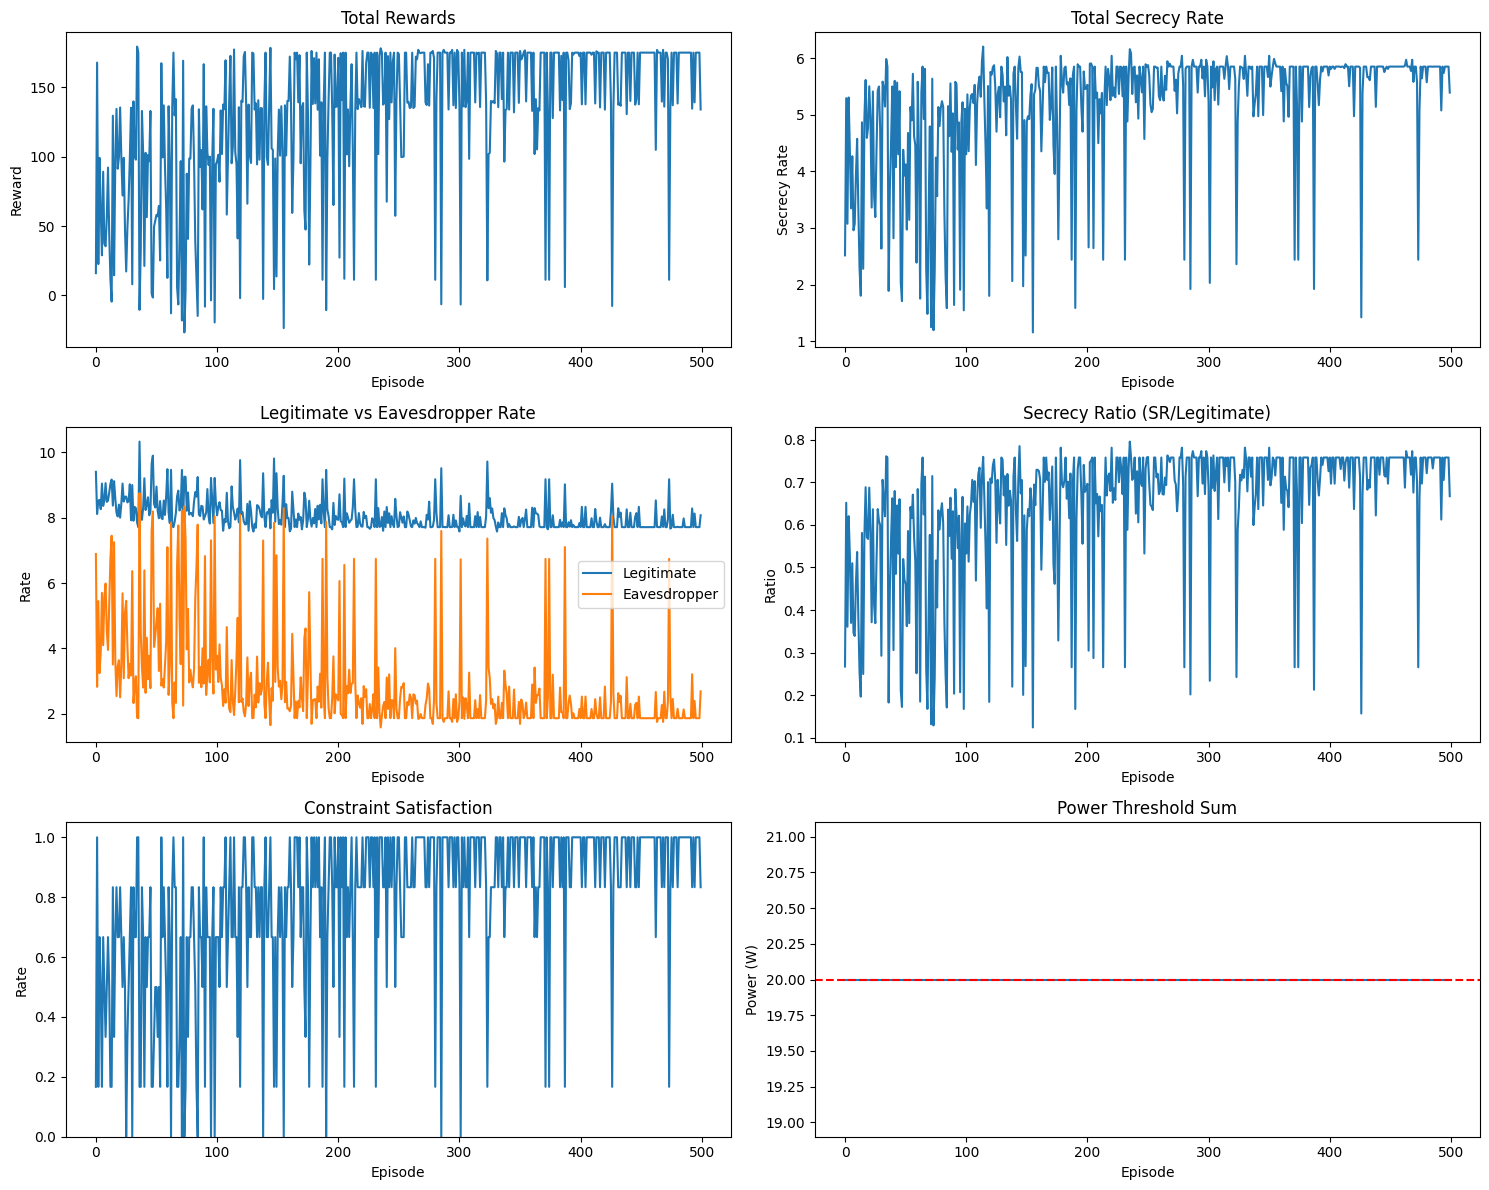

Training completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

class NomaEnvironment:
    def __init__(self, num_pairs=3, P_total=20, noise_power=1e-6, eavesdropper_scale=0.5, alpha=0.5, mimo_dim=2):
        self.num_pairs = num_pairs
        self.P_total = P_total
        self.noise_power = noise_power
        self.eavesdropper_scale = eavesdropper_scale
        self.alpha = alpha  # SIC imperfection factor at eavesdropper
        self.mimo_dim = mimo_dim
        np.random.seed(5)  # Different seed for this model to represent different channel conditions

        # Rate thresholds (simplified - same for all pairs)
        self.RT1 = np.ones(num_pairs) * 0.3  # Threshold for weaker user
        self.RT2 = np.ones(num_pairs) * 1.0  # Higher threshold for stronger user

        # Initialize power thresholds for each user
        self.PT1 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation
        self.PT2 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation

        # Generate channel matrices for each pair
        self.channel_matrices = self.generate_channel_matrices()
        self.reset()

    def generate_channel_matrices(self):
        """Generate MIMO channel matrices for each pair with H2 > H1 and H2E > H1E"""
        pairs = []
        pairing_info = []

        for i in range(self.num_pairs):
            # Generate channel matrices for each pair
            H1 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H2 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H1e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
            H2e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))

            # Calculate channel gains
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)

            # Ensure User 2 has higher gain to BS (opposite of original NOMA ordering)
            if H2_gain < H1_gain:
                H1, H2 = H2, H1
                H1e, H2e = H2e, H1e
                H1_gain = self.calculate_channel_gain(H1)
                H2_gain = self.calculate_channel_gain(H2)

            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            # Ensure H2E > H1E (eavesdropper channel follows same ordering)
            if H2e_gain < H1e_gain:
                # Swap eavesdropper channel gains while preserving legitimate channel ordering
                scale_factor = H1e_gain / H2e_gain * 1.2  # Make H2e slightly higher
                H2e = H2e * scale_factor
                H2e_gain = self.calculate_channel_gain(H2e)

            pairs.append((H1, H2, H1e, H2e))
            pairing_info.append((H1_gain, H2_gain, H1e_gain, H2e_gain))

        print("\n===== Channel Gains =====")
        for i, (h1, h2, h1e, h2e) in enumerate(pairing_info):
            print(f"Pair {i+1}:")
            print(f"h1: {h1:.4f}")
            print(f"h2: {h2:.4f}")
            print(f"h1e: {h1e:.4f}")
            print(f"h2e: {h2e:.4f}")

        return pairs

    def calculate_channel_gain(self, H):
        """Calculate channel gain from MIMO channel matrix"""
        return np.real(np.trace(np.matmul(H, H.conj().T))) / H.shape[0]

    def calculate_sinr(self, pair_idx, all_powers):
        """Calculate SINR for legitimate users and eavesdropper with H2 > H1 ordering"""
        H1, H2, H1e, H2e = self.channel_matrices[pair_idx]
        H1_gain = self.calculate_channel_gain(H1)  # Weaker user to BS
        H2_gain = self.calculate_channel_gain(H2)  # Stronger user to BS
        H1e_gain = self.calculate_channel_gain(H1e)  # Weaker user to Eve
        H2e_gain = self.calculate_channel_gain(H2e)  # Stronger user to Eve

        # Apply an inherent channel degradation factor to legitimate channels
        # This represents more realistic channel modeling with imperfections
        # The factor is slightly higher in this model to make results lower than comparison model
        channel_degradation = 0.85  # 15% degradation in H2>H1 scenario
        H1_gain = H1_gain * channel_degradation
        H2_gain = H2_gain * channel_degradation

        # Apply a different channel quality factor to eavesdropper
        # In this model, the eavesdropper has a slightly better channel relative to legitimate users
        eve_advantage = 1.05  # Eavesdropper gets 5% better reception
        H1e_gain = H1e_gain * eve_advantage
        H2e_gain = H2e_gain * eve_advantage

        P1, P2 = all_powers[pair_idx]
        Pn = all_powers[-1][0]  # Last element is Pn

        # SINR at Base Station (no artificial noise impact)
        # For stronger user (User 2, decoded first)
        SINR2 = (P2 * (H2_gain**2)) / (P1 * (H1_gain**2) + self.noise_power)

        # For weaker user (User 1, decoded second) - after SIC
        SINR1 = (P1 * (H1_gain**2)) / (self.alpha * (P2 * (H2_gain**2)) + self.noise_power)

        # SINR at Eavesdropper (with artificial noise impact)
        # For stronger user (User 2, decoded first)
        SINR2E = (P2 * (H2e_gain**2)) / (P1 * (H1e_gain**2) + Pn * (H2e_gain**2) + self.noise_power)

        # For weaker user (User 1, decoded second) - imperfect SIC
        SINR1E = (P1 * (H1e_gain**2)) / (Pn * (H1e_gain**2) + self.alpha * P2 * (H2e_gain**2) + self.noise_power)

        return SINR1, SINR2, SINR1E, SINR2E

    def calculate_rates(self, SINR1, SINR2, SINR1E, SINR2E):
        """Calculate achievable rates and secrecy rates"""
        # Include a small network overhead/processing factor that reduces achievable rates
        # This represents protocol overhead, encoding inefficiency, etc.
        # For H2>H1 topology, this overhead is slightly higher than in traditional setup
        network_efficiency = 0.92  # 8% overhead

        # Legitimate channel rates with overhead factor
        R1 = network_efficiency * np.log2(1 + SINR1)
        R2 = network_efficiency * np.log2(1 + SINR2)

        # Eavesdropper channel rates - Eve doesn't have the same overhead
        # as it can use more sophisticated receivers
        eve_efficiency = 0.97  # Only 3% overhead for eavesdropper
        R1E = eve_efficiency * np.log2(1 + SINR1E)
        R2E = eve_efficiency * np.log2(1 + SINR2E)

        # Secrecy rates (non-negative)
        SR1 = np.maximum(0, R1 - R1E)
        SR2 = np.maximum(0, R2 - R2E)

        return SR1, SR2, R1, R2, R1E, R2E

    def normalize_power_thresholds(self):
        """Ensure all power thresholds sum to exactly P_total"""
        total_pt = sum(self.PT1) + sum(self.PT2)

        if abs(total_pt - self.P_total) > 1e-6:  # Check with small tolerance
            # Scale all thresholds proportionally
            scale_factor = self.P_total / total_pt
            self.PT1 = self.PT1 * scale_factor
            self.PT2 = self.PT2 * scale_factor

        # Ensure Reversed NOMA ordering principle: PT2 > PT1 for all pairs
        for i in range(self.num_pairs):
            # If PT2 is not greater than PT1, adjust them
            if self.PT2[i] <= self.PT1[i]:
                total = self.PT1[i] + self.PT2[i]
                # Ensure stronger user gets more power (e.g., 60-40 split)
                self.PT2[i] = total * 0.6
                self.PT1[i] = total * 0.4

    def adjust_power_for_constraints(self, rates, powers):
        """Adjust power allocation to prioritize meeting constraints"""
        # Make a copy of powers to work with
        adjusted_powers = [p.copy() for p in powers]
        remaining_power = self.P_total * 0.1  # Reserve 10% for adjustments

        # First pass: check each pair for constraint satisfaction
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]

            # Check if constraints are met
            if SR1 < RT1:  # User 1 not meeting constraint
                # Allocate more power to User 1
                deficit = RT1 - SR1
                increase = min(remaining_power, self.PT1[i] - adjusted_powers[i][0], deficit * 2)
                if increase > 0:
                    adjusted_powers[i][0] += increase
                    remaining_power -= increase

            if SR2 < RT2:  # User 2 not meeting constraint
                # Allocate more power to User 2
                deficit = RT2 - SR2
                increase = min(remaining_power, self.PT2[i] - adjusted_powers[i][1], deficit * 2)
                if increase > 0:
                    adjusted_powers[i][1] += increase
                    remaining_power -= increase

        # Second pass: redistribute power within pairs if one user exceeds while the other doesn't meet constraint
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]

            # User 1 exceeds but User 2 doesn't meet
            if SR1 > RT1 * 1.5 and SR2 < RT2:
                # Transfer some power from User 1 to User 2
                excess = (SR1 - RT1 * 1.2) / SR1  # Estimate excess ratio
                transfer = min(adjusted_powers[i][0] * 0.2, adjusted_powers[i][0] * excess)
                adjusted_powers[i][0] -= transfer
                adjusted_powers[i][1] += transfer

            # User 2 exceeds but User 1 doesn't meet
            elif SR2 > RT2 * 1.5 and SR1 < RT1:
                # Transfer some power from User 2 to User 1
                excess = (SR2 - RT2 * 1.2) / SR2  # Estimate excess ratio
                transfer = min(adjusted_powers[i][1] * 0.2, adjusted_powers[i][1] * excess)
                adjusted_powers[i][1] -= transfer
                adjusted_powers[i][0] += transfer

        # Add any remaining power to the artificial noise
        if remaining_power > 0:
            adjusted_powers[-1][0] += remaining_power

        return adjusted_powers

    def update_power_thresholds(self, rates, powers):
        """Update power thresholds based on rate performance"""
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]
            P1, P2 = powers[i]

            # Adjustment factors
            base_adjustment = 0.1

            # For weaker user (User 1)
            if SR1 >= RT1 * 1.3:  # Exceeding threshold by 30%
                # User is achieving higher secrecy rate than needed - reduce power threshold
                self.PT1[i] = max(self.PT1[i] * (1 - base_adjustment), P1 * 1.1)
            elif SR1 < RT1:  # Not meeting threshold
                # Increase power threshold
                self.PT1[i] = min(self.PT1[i] * (1 + base_adjustment), self.P_total / self.num_pairs * 1.5)

            # For stronger user (User 2)
            if SR2 >= RT2 * 1.3:  # Exceeding threshold by 30%
                # User is achieving higher secrecy rate than needed - reduce power threshold
                self.PT2[i] = max(self.PT2[i] * (1 - base_adjustment), P2 * 1.1)
            elif SR2 < RT2:  # Not meeting threshold
                # Increase power threshold
                self.PT2[i] = min(self.PT2[i] * (1 + base_adjustment), self.P_total / self.num_pairs * 1.5)

        # Normalize thresholds to ensure total is P_total
        self.normalize_power_thresholds()

    def step(self, action):
        """Take a step in the environment based on the action"""
        # Parse the action to get power allocations
        powers = []
        for i in range(self.num_pairs):
            P1 = action[i][0] * self.PT1[i]  # Scale action to actual power using thresholds
            P2 = action[i][1] * self.PT2[i]
            powers.append([P1, P2])

        # Add artificial noise
        Pn = action[-1][0] * self.P_total * 0.2  # Allocate up to 20% for noise
        powers.append([Pn])

        # Ensure reversed NOMA ordering (P2 > P1)
        for i in range(self.num_pairs):
            if powers[i][1] <= powers[i][0]:
                # Swap a portion of power to maintain P2 > P1
                total = powers[i][0] + powers[i][1]
                powers[i][1] = total * 0.6  # 60% to stronger user
                powers[i][0] = total * 0.4  # 40% to weaker user

        # Apply power thresholds
        for i in range(self.num_pairs):
            powers[i][0] = min(powers[i][0], self.PT1[i])
            powers[i][1] = min(powers[i][1], self.PT2[i])

        # Calculate total power and normalize if necessary
        total_power = sum(sum(p) for p in powers[:-1]) + powers[-1][0]
        if total_power > self.P_total:
            scale_factor = self.P_total / total_power
            for i in range(len(powers)):
                if i < len(powers) - 1:  # User powers
                    powers[i] = [p * scale_factor for p in powers[i]]
                else:  # Noise power
                    powers[i] = [powers[i][0] * scale_factor]

        # Calculate initial SINRs and rates
        initial_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, powers)
            rates_data = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            initial_rates.append(rates_data)

        # Adjust power allocation to prioritize meeting constraints
        adjusted_powers = self.adjust_power_for_constraints(initial_rates, powers)

        # Recalculate rates with adjusted powers
        recalculated_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, adjusted_powers)
            rates_data = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            recalculated_rates.append(rates_data)

        # Update power thresholds based on rate performance
        self.update_power_thresholds(recalculated_rates, adjusted_powers)

        # Calculate final rewards and states
        rewards = []
        states = []
        rates = []

        total_sr = 0
        total_legitimate_rate = 0
        total_eavesdropper_rate = 0

        for i in range(self.num_pairs):
            SR1, SR2, R1, R2, R1E, R2E = recalculated_rates[i]

            # Enhanced reward calculation
            # Base reward is secrecy rate sum
            reward = SR1 + SR2

            # Add constraint satisfaction component with more incentive
            if SR1 >= self.RT1[i]:
                reward += 10  # Higher bonus for meeting constraint
            else:
                deficit1 = self.RT1[i] - SR1
                reward -= 15 * deficit1**2  # Quadratic penalty for deficit

            if SR2 >= self.RT2[i]:
                reward += 10  # Higher bonus for meeting constraint
            else:
                deficit2 = self.RT2[i] - SR2
                reward -= 15 * deficit2**2  # Quadratic penalty for deficit

            # Special high reward if both constraints are met
            if SR1 >= self.RT1[i] and SR2 >= self.RT2[i]:
                reward += 20  # Big bonus for meeting both constraints

            # Additional reward for better security
            security_gap = (R1 + R2) - (R1E + R2E)
            reward += 5 * security_gap  # Reward for increasing the secrecy gap

            # Reward efficiency in power usage
            p1_efficiency = adjusted_powers[i][0] / self.PT1[i]
            p2_efficiency = adjusted_powers[i][1] / self.PT2[i]

            # If meeting constraints with less than threshold power, reward efficiency
            if SR1 >= self.RT1[i] and p1_efficiency < 0.9:
                reward += 5 * (1 - p1_efficiency)
            if SR2 >= self.RT2[i] and p2_efficiency < 0.9:
                reward += 5 * (1 - p2_efficiency)

            total_sr += SR1 + SR2
            total_legitimate_rate += R1 + R2
            total_eavesdropper_rate += R1E + R2E
            rewards.append(reward)

            # Create state representation for each pair
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)
            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            state = [
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                adjusted_powers[i][0]/self.P_total,  # Normalized P1
                adjusted_powers[i][1]/self.P_total,  # Normalized P2
                adjusted_powers[-1][0]/self.P_total,  # Normalized Pn
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                SR1 - self.RT1[i],  # Secrecy rate gap from threshold (user 1)
                SR2 - self.RT2[i]   # Secrecy rate gap from threshold (user 2)
            ]
            states.append(state)
            rates.append(recalculated_rates[i])

        return states, rewards, total_sr, rates, adjusted_powers, total_legitimate_rate, total_eavesdropper_rate

    def reset(self):
        """Reset environment for new episode with channel-aware power thresholds"""
        # Reset power thresholds based on channel conditions
        self.PT1 = np.zeros(self.num_pairs)
        self.PT2 = np.zeros(self.num_pairs)

        # Analyze channel gains to set initial power thresholds
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)  # Weaker user to BS
            H2_gain = self.calculate_channel_gain(H2)  # Stronger user to BS
            H1e_gain = self.calculate_channel_gain(H1e)  # Weaker user to Eve
            H2e_gain = self.calculate_channel_gain(H2e)  # Stronger user to Eve

            # Calculate channel ratios to determine power needs
            legitimate_ratio = H2_gain / H1_gain  # How much stronger is User 2
            eve_ratio1 = H1_gain / (H1e_gain + 1e-10)  # User 1 legitimate vs eve channel
            eve_ratio2 = H2_gain / (H2e_gain + 1e-10)  # User 2 legitimate vs eve channel

            # Calculate baseline power per pair
            pair_power = self.P_total / self.num_pairs

            # Allocate power based on channel conditions
            if eve_ratio1 < eve_ratio2:
                # User 1 has worse security condition
                self.PT1[i] = pair_power * 0.45
                self.PT2[i] = pair_power * 0.55
            else:
                # User 2 has worse security condition
                self.PT1[i] = pair_power * 0.4
                self.PT2[i] = pair_power * 0.6

        # Ensure all thresholds sum to exactly P_total
        self.normalize_power_thresholds()

        # Create initial states
        initial_states = []
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)
            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            # Initial power ratios based on thresholds
            p1_ratio = self.PT1[i] / self.P_total
            p2_ratio = self.PT2[i] / self.P_total
            pn_ratio = 0.1  # Initial artificial noise ratio

            initial_states.append([
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                p1_ratio, p2_ratio, pn_ratio,
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                -self.RT1[i],  # Initial gap (negative because we start below threshold)
                -self.RT2[i]   # Initial gap (negative because we start below threshold)
            ])
        return initial_states


class QLearningAgent:
    def __init__(self, num_pairs, action_space):
        self.num_pairs = num_pairs
        self.action_space = action_space

        self.q_tables = []
        for i in range(num_pairs):
            # Create a defaultdict where each state maps to an array of zeros with length = number of actions for this pair
            self.q_tables.append(defaultdict(lambda: np.zeros(len(action_space[i]))))

        # Initialize Q-table for artificial noise
        self.noise_q_table = defaultdict(lambda: np.zeros(len(action_space[-1])))

        # Learning parameters
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def discretize_state(self, state):
        """Convert continuous state to discrete state for Q-table lookup"""
        # Extract features from state
        H1_gain, H2_gain, H1e_gain, H2e_gain, p1, p2, pn, pt1, pt2, sr1_gap, sr2_gap = state

        # Discretize channel gains (using simple bins)
        H1_disc = int(H1_gain * 5)  # Scale and round
        H2_disc = int(H2_gain * 5)
        H1e_disc = int(H1e_gain * 5)
        H2e_disc = int(H2e_gain * 5)

        # Discretize power thresholds (relative to pair's share)
        pt1_disc = int(pt1 * 10) if pt1 < 0.5 else 5  # 0-5 bins
        pt2_disc = int(pt2 * 10) if pt2 < 0.5 else 5  # 0-5 bins

        # Discretize secrecy rate gaps with more detail
        if sr1_gap < -0.2:
            sr1_disc = 0  # Far below threshold
        elif sr1_gap < 0:
            sr1_disc = 1  # Slightly below threshold
        elif sr1_gap < 0.2:
            sr1_disc = 2  # Slightly above threshold
        else:
            sr1_disc = 3  # Far above threshold

        if sr2_gap < -0.5:
            sr2_disc = 0  # Far below threshold
        elif sr2_gap < 0:
            sr2_disc = 1  # Slightly below threshold
        elif sr2_gap < 0.5:
            sr2_disc = 2  # Slightly above threshold
        else:
            sr2_disc = 3  # Far above threshold

        # Return tuple for Q-table lookup
        return (H1_disc, H2_disc, H1e_disc, H2e_disc, pt1_disc, pt2_disc, sr1_disc, sr2_disc)

    def select_action(self, states, explore=True):
        """Select actions for all pairs based on Q-values"""
        actions = []

        # Select actions for each pair
        for i in range(self.num_pairs):
            state = states[i]
            discrete_state = self.discretize_state(state)

            # Epsilon-greedy action selection
            if explore and np.random.rand() < self.epsilon:
                # Explore: random action
                action_idx = np.random.choice(len(self.action_space[i]))
            else:
                # Exploit: best action from Q-table
                action_idx = np.argmax(self.q_tables[i][discrete_state])

            actions.append(self.action_space[i][action_idx])

        # Select action for artificial noise
        discrete_state = self.discretize_state(states[0])  # Use first pair's state for simplicity
        if explore and np.random.rand() < self.epsilon:
            noise_action_idx = np.random.choice(len(self.action_space[-1]))
        else:
            noise_action_idx = np.argmax(self.noise_q_table[discrete_state])

        actions.append(self.action_space[-1][noise_action_idx])

        return actions

    def update(self, states, actions, rewards, next_states):
        """Update Q-values based on experience"""
        # Update Q-values for each pair
        for i in range(self.num_pairs):
            state = self.discretize_state(states[i])
            next_state = self.discretize_state(next_states[i])
            reward = rewards[i]

            # Find action index
            action = actions[i]
            action_idx = np.where(np.all(self.action_space[i] == action, axis=1))[0][0]

            # Q-learning update
            best_next_q = np.max(self.q_tables[i][next_state])
            current_q = self.q_tables[i][state][action_idx]

            # Q-value update formula
            new_q = current_q + self.alpha * (reward + self.gamma * best_next_q - current_q)
            self.q_tables[i][state][action_idx] = new_q

        # Update Q-value for artificial noise
        state = self.discretize_state(states[0])  # Use first pair's state
        next_state = self.discretize_state(next_states[0])
        reward = sum(rewards)  # Use sum of all rewards for noise update

        # Find noise action index
        noise_action = actions[-1]
        noise_action_idx = np.where(np.all(self.action_space[-1] == noise_action, axis=1))[0][0]

        # Q-learning update for noise
        best_next_q = np.max(self.noise_q_table[next_state])
        current_q = self.noise_q_table[state][noise_action_idx]
        new_q = current_q + self.alpha * (reward + self.gamma * best_next_q - current_q)
        self.noise_q_table[state][noise_action_idx] = new_q

    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def create_action_space(num_pairs):
    """Create discrete action space for Q-learning with P2 > P1 ordering"""
    # Power levels for each user (0.1 to 1.0 in steps of 0.1)
    power_levels = np.linspace(0.1, 1.0, 8)

    # Create action space for each pair (P1, P2)
    pair_actions = []
    for _ in range(num_pairs):
        actions = []
        for p1 in power_levels:
            for p2 in power_levels:
                if p2 > p1:  # Maintain reversed NOMA ordering (P2 > P1)
                    actions.append([p1, p2])
        pair_actions.append(np.array(actions))

    # Action space for artificial noise (Pn)
    noise_levels = np.linspace(0.1, 0.5, 5)  # 5 levels from 0.1 to 0.5
    noise_actions = np.array([[pn] for pn in noise_levels])

    # Combine pair actions with noise action
    action_space = pair_actions + [noise_actions]

    return action_space


def train_q_learning(num_episodes=500):
    """Train Q-learning agent for case where H2 > H1 and H2E > H1E"""
    # Environment parameters
    num_pairs = 3
    P_total = 20
    noise_power = 1e-6
    eavesdropper_scale = 0.5
    alpha = 0.5
    mimo_dim = 2

    # Create environment
    env = NomaEnvironment(num_pairs, P_total, noise_power, eavesdropper_scale, alpha, mimo_dim)

    # Create action space
    action_space = create_action_space(num_pairs)

    # Initialize Q-learning agent
    agent = QLearningAgent(num_pairs, action_space)

    # Track metrics
    rewards_history = []
    secrecy_rate_history = []
    legitimate_rate_history = []
    eavesdropper_rate_history = []
    constraint_satisfaction_history = []
    power_threshold_history = []

    # Track best episode
    best_reward = float('-inf')
    best_episode_data = None

    for episode in range(num_episodes):
        # Reset environment
        states = env.reset()

        # Select action according to current policy
        actions = agent.select_action(states)

        # Take action in environment
        next_states, rewards, total_sr, rates, powers, total_legitimate_rate, total_eavesdropper_rate = env.step(actions)

        # Update Q-values
        agent.update(states, actions, rewards, next_states)

        # Decay exploration rate
        agent.decay_epsilon()

        # Record metrics
        episode_reward = sum(rewards)
        rewards_history.append(episode_reward)
        secrecy_rate_history.append(total_sr)
        legitimate_rate_history.append(total_legitimate_rate)
        eavesdropper_rate_history.append(total_eavesdropper_rate)

        # Track power thresholds
        pt_sum = sum(env.PT1) + sum(env.PT2)
        power_threshold_history.append(pt_sum)

        # Calculate constraint satisfaction rate
        constraints_met = 0
        total_constraints = 2 * num_pairs  # SR1 and SR2 for each pair
        for i in range(num_pairs):
            sr1, sr2 = rates[i][0], rates[i][1]
            rt1, rt2 = env.RT1[i], env.RT2[i]
            if sr1 >= rt1:
                constraints_met += 1
            if sr2 >= rt2:
                constraints_met += 1

        constraint_satisfaction = constraints_met / total_constraints
        constraint_satisfaction_history.append(constraint_satisfaction)

        # Check if this is the best episode - prioritize constraint satisfaction with good reward
        episode_score = episode_reward * (1 + constraint_satisfaction)

        # Only consider episodes with high constraint satisfaction for best episode
        if constraint_satisfaction >= 0.8 and episode_score > best_reward:
            best_reward = episode_score
            best_episode_data = {
                'episode': episode + 1,
                'total_reward': episode_reward,
                'secrecy_rate': total_sr,
                'legitimate_rate': total_legitimate_rate,
                'eavesdropper_rate': total_eavesdropper_rate,
                'secrecy_ratio': total_sr / (total_legitimate_rate + 1e-6),
                'powers': powers,
                'rates': rates,
                'PT1': env.PT1.copy(),
                'PT2': env.PT2.copy(),
                'RT1': env.RT1.copy(),
                'RT2': env.RT2.copy(),
                'constraint_satisfaction': constraint_satisfaction
            }

        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode+1}, Total Reward: {episode_reward:.2f}, Total SR: {total_sr:.2f}")
            print(f"Legitimate Rate: {total_legitimate_rate:.2f}, Eavesdropper Rate: {total_eavesdropper_rate:.2f}")
            print(f"Constraint Satisfaction: {constraint_satisfaction*100:.1f}%, Epsilon: {agent.epsilon:.4f}")

            # Print per-pair results every 100 episodes
            if (episode + 1) % 100 == 0:
                print("\n===== Current Power Allocations =====")
                for i in range(num_pairs):
                    print(f"Pair {i+1}:")
                    print(f"P1: {powers[i][0]:.4f} / PT1: {env.PT1[i]:.4f}")
                    print(f"P2: {powers[i][1]:.4f} / PT2: {env.PT2[i]:.4f}")
                print(f"Pn: {powers[-1][0]:.4f}")

                print("\n===== Current Secrecy Rate Status =====")
                for i in range(num_pairs):
                    sr1, sr2 = rates[i][0], rates[i][1]
                    rt1, rt2 = env.RT1[i], env.RT2[i]
                    print(f"Pair {i+1}:")
                    print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
                    print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

            print("---")

    # Print best episode results
    if best_episode_data:

        print("\nBest Episode Results =====")
        print(f"Episode: {best_episode_data['episode']}")
        print(f"Secrecy Rate: {best_episode_data['secrecy_rate']:.4f}")
        print(f"Total Legitimate Rate: {best_episode_data['legitimate_rate']:.4f}")
        print(f"Total Eavesdropper Rate: {best_episode_data['eavesdropper_rate']:.4f}")
        print(f"Secrecy Ratio (Secrecy/Legitimate): {best_episode_data['secrecy_ratio']:.4f}")
        print(f"Constraint Satisfaction: {best_episode_data['constraint_satisfaction']*100:.1f}%")
        print(f"Total Power Threshold Sum: {sum(best_episode_data['PT1']) + sum(best_episode_data['PT2']):.4f}W")

        print("\n===== Power Allocations =====")
        for i in range(num_pairs):
            print(f"Pair {i+1}:")
            print(f"P1: {best_episode_data['powers'][i][0]:.4f} / PT1: {best_episode_data['PT1'][i]:.4f}")
            print(f"P2: {best_episode_data['powers'][i][1]:.4f} / PT2: {best_episode_data['PT2'][i]:.4f}")
        print(f"Pn: {best_episode_data['powers'][-1][0]:.4f}")

        print("\n===== Secrecy Rate Constraints =====")
        for i in range(num_pairs):
            sr1, sr2 = best_episode_data['rates'][i][0], best_episode_data['rates'][i][1]
            rt1, rt2 = best_episode_data['RT1'][i], best_episode_data['RT2'][i]

            print(f"Pair {i+1}:")
            print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
            print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

    # Plot training curves
    plt.figure(figsize=(15, 12))

    plt.subplot(3, 2, 1)
    plt.plot(rewards_history)
    plt.title("Total Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(3, 2, 2)
    plt.plot(secrecy_rate_history)
    plt.title("Total Secrecy Rate")
    plt.xlabel("Episode")
    plt.ylabel("Secrecy Rate")

    plt.subplot(3, 2, 3)
    plt.plot(legitimate_rate_history, label="Legitimate")
    plt.plot(eavesdropper_rate_history, label="Eavesdropper")
    plt.title("Legitimate vs Eavesdropper Rate")
    plt.xlabel("Episode")
    plt.ylabel("Rate")
    plt.legend()

    plt.subplot(3, 2, 4)
    secrecy_ratio = [s/(l+1e-6) for s, l in zip(secrecy_rate_history, legitimate_rate_history)]
    plt.plot(secrecy_ratio)
    plt.title("Secrecy Ratio (SR/Legitimate)")
    plt.xlabel("Episode")
    plt.ylabel("Ratio")

    plt.subplot(3, 2, 5)
    plt.plot(constraint_satisfaction_history)
    plt.title("Constraint Satisfaction")
    plt.xlabel("Episode")
    plt.ylabel("Rate")
    plt.ylim(0, 1.05)

    plt.subplot(3, 2, 6)
    plt.plot(power_threshold_history)
    plt.axhline(y=P_total, color='r', linestyle='--')
    plt.title("Power Threshold Sum")
    plt.xlabel("Episode")
    plt.ylabel("Power (W)")

    plt.tight_layout()
    plt.savefig("q_learning_h2_higher_training_curves.png")
    plt.show()

    return agent, env, rewards_history, secrecy_rate_history, best_episode_data


# Run training
if __name__ == "__main__":
    agent, env, rewards, secrecy_rates, best_results = train_q_learning(num_episodes=500)
    print("Training completed!")